<a href="https://colab.research.google.com/github/Miguel1789/Prediccion-del-indice-S-P-500/blob/main/Tesis_Predicci%C3%B3n_del_SP%26500_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICCION DE PRECIOS DEL SP&500**

En el siguiente notebook vamos a predecir los precios del indice SP&500. Los datos han sido obtenidos de la pagina de Twelve Data.com. Se ha considerado un lapso de 2 años, con un período de registro diario.

In [ ]:
#conda install h5py==2.10.0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                    
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **IMPORTACION DE DATOS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UNIR/FIN DE MASTER/BASES DE DATOS/Base Reducida CSV.csv')

# **ESCOGIENDO UNA SEMILLA**

In [ ]:
import tensorflow as tf
import numpy as np

seed = 12
tf.random.set_seed(seed)
np.random.seed(seed)

# **GRAFICO DEL PRECIO DE CIERRE**

In [ ]:
#Formateamos el dato fecha para que sea del tipo correcto
df.datetime= pd.to_datetime(df.datetime)

#Es importante para una serie temporal que los datos esten ordenados de más nuevo a más antiguo
df=df.sort_values("datetime")

#Establecemos la fecha como indice
df= df.set_index("datetime")

#Restablecemos a índice numérico para realizar operaciones
df=df.reset_index()

df.head()

,datetime,open,high,low,close,volume,ma,ema,macd,macd_signal,...,ad,aroon_down,aroon_up,supertrend,correl,mfi,Tweets Negativos,Tweets Indiferentes,Tweets Positivos,Tweets Ponderados
0,2020-04-08,2685.00000,2760.75000,2663.30005,2749.97998,5856370000,2627.24883,2654.17041,35.57144,5.36852,...,6.344565e+09,28.57143,100.00000,2387.38749,0.76371,65.53037,0,0,3,1.000000
1,2020-04-09,2776.98999,2818.57007,2762.36011,2789.82007,7880140000,2689.83887,2702.87948,52.64621,21.22918,...,6.007452e+09,14.28571,100.00000,2492.12638,0.75104,80.02560,6,7,4,-0.117647
2,2020-04-13,2782.45996,2782.45996,2721.16992,2761.62988,5274310000,2731.28331,2723.95603,57.02950,33.86259,...,8.385008e+09,0.00000,85.71429,2492.12638,0.50575,86.27138,14,15,17,0.065217
3,2020-04-14,2805.10010,2851.85010,2805.10010,2846.06006,5567400000,2772.35110,2767.81907,69.33698,45.82984,...,1.413807e+10,0.00000,100.00000,2564.44334,0.61038,77.01337,6,7,11,0.208333
4,2020-04-15,2795.63989,2801.87988,2761.54004,2783.36011,5203390000,2790.04555,2773.49701,65.28774,53.19205,...,1.477551e+10,0.00000,85.71429,2564.44334,0.65679,74.80067,4,6,5,0.066667


Text(0.5, 1.0, 'SP&500')

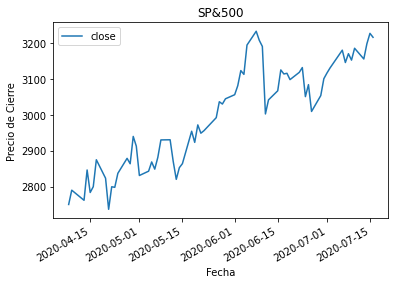

In [ ]:
df.plot(x="datetime",y="close")
plt.figsize=(16,5)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('SP&500')


# **PREPROCESO DE DATOS**

Proceso de expansión de características.

In [ ]:
#Preproceso Min-Max Scaling [0,1] para las variables determinadas
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

dfmin=df[['open', 'high','low','close','volume','ma','ema','rsi','sar','adx',
          'STOCH slow_k','STOCH slow_d','stddev','BBANDS upper_band',
          'BBANDS middle_band','BBANDS lower_band','willr','percent_b',
          'obv','aroon_down','aroon_up','supertrend','mfi','Tweets Negativos',
          'Tweets Indiferentes','Tweets Positivos']]

scaler.fit(dfmin)
scaled_data = scaler.transform(dfmin)

dft1=pd.DataFrame(scaled_data)
dft1.columns=['open0', 'high0','low0','close0','volume0','ma0','ema0','rsi0','sar0','adx0',
          'STOCH slow_k0','STOCH slow_d0','stddev0','BBANDS upper_band0',
          'BBANDS middle_band0','BBANDS lower_band0','willr0','percent_b0',
          'obv0','aroon_down0','aroon_up0','supertrend0','mfi0','Tweets Negativos0',
          'Tweets Indiferentes0','Tweets Positivos0']

In [ ]:
#Preproceso Min-Max Scaling [-1,1] para las variables determinadas
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

dfmin=df[['macd','macd_signal','macd_hist','ppo','cci','ad','correl','Tweets Ponderados']]

scaler.fit(dfmin)
scaled_data = scaler.transform(dfmin)

dft2=pd.DataFrame(scaled_data)
dft2.columns=['macd1','macd_signal1','macd_hist1','ppo1','cci1','ad1','correl1','Tweets Ponderados1']

In [ ]:
#Preproceso Fluctuación para las variables determinadas
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

df0=df
df0=df0.drop([0],axis=0)
nueva_fila=df0.loc[[len(df0)],:]
df0=df0.append(nueva_fila, ignore_index=True)
col_flu=['open','high','low','volume','ma','ema','rsi','sar','adx','stddev','ad','supertrend']

dfflu=(df[col_flu]-df0[col_flu])/df0[col_flu]

scaler.fit(dfflu)
scaled_data = scaler.transform(dfflu)

dft3=pd.DataFrame(scaled_data)
dft3.columns=['openf', 'highf','lowf','volumef','maf','emaf','rsif','sarf','adxf',
          'stddevf', 'adf','supertrendf']

In [ ]:
#Preproceso Control para las variables determinadas
import numpy as np
#Para estas variables solo se controla si esta por encima o debajo de 0
dfcon1=df[['macd','macd_signal','macd_hist','ppo']]

dfcon1=pd.DataFrame(np.sign(dfcon1))
dfcon1.columns=['macdc','macd_signalc','macd_histc','ppoc']

In [ ]:
#Para variables con sus propios parámetros de control
dfcon2=df[['rsi','adx','STOCH slow_k','STOCH slow_d','willr','cci','percent_b','mfi']]
cond=pd.DataFrame({'var':['rsi','adx','STOCH slow_k','STOCH slow_d',
                          'willr','cci','percent_b','mfi'],
                   'max':[70,40,80,80,-20,100,0.8,80],
                   'min':[30,25,20,20,-80,-100,0.2,20]})
for j in range(0,len(cond)):
  for i in range(0,len(df)):
    if df.loc[i,cond.loc[j,'var']]>cond.loc[j,'max']:
      dfcon2.loc[i,cond.loc[j,'var']]=1
    else:
      if df.loc[i,cond.loc[j,'var']]<cond.loc[j,'min']:
        dfcon2.loc[i,cond.loc[j,'var']]=-1
      else:
        dfcon2.loc[i,cond.loc[j,'var']]=0

dfcon2.columns=['rsic','adxc','STOCH slow_kc','STOCH slow_dc','willrc','ccic','percent_bc','mfic']

In [ ]:
#Estas variables se comparan con parámetros dinámicos
dfcon31=df[['BBANDS upper_band','BBANDS lower_band','aroon_down','aroon_up']]
dfcon32=df[['close','close','aroon_up','aroon_down']]
dfcon32.columns=['BBANDS upper_band','BBANDS lower_band','aroon_down','aroon_up']
dfcon3=pd.DataFrame(np.sign(dfcon31.sub(dfcon32)))

dfcon3.columns=['BBANDS upper_bandc','BBANDS lower_bandc','aroon_downc','aroon_upc']

dft4=pd.concat([dfcon1,dfcon2,dfcon3], axis=1)

In [ ]:
#Uniendo todas las variables en una nueva dataframe
dft=pd.concat([df['datetime'],dft1,dft2,dft3,dft4], axis=1)
display(dft)


,datetime,open0,high0,low0,close0,volume0,ma0,ema0,rsi0,sar0,...,STOCH slow_kc,STOCH slow_dc,willrc,ccic,percent_bc,mfic,BBANDS upper_bandc,BBANDS lower_bandc,aroon_downc,aroon_upc
0,2020-04-08,0.000000,0.000000,0.000000,0.027066,0.408072,0.000000,0.000000,0.545467,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,1.0
1,2020-04-09,0.170043,0.121082,0.184312,0.107416,0.841911,0.110123,0.091984,0.594018,0.092798,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0
2,2020-04-13,0.180154,0.045463,0.107673,0.050561,0.283295,0.183042,0.131785,0.525405,0.174852,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,-1.0,-1.0,1.0
3,2020-04-14,0.222005,0.190774,0.263834,0.220842,0.346125,0.255298,0.214618,0.639520,0.223483,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,1.0
4,2020-04-15,0.204518,0.086130,0.182786,0.094387,0.268091,0.286430,0.225340,0.481224,0.422093,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2020-07-10,0.864117,0.892237,0.879917,0.904504,0.120593,0.896575,0.920115,0.496419,0.732009,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,1.0
65,2020-07-13,0.961367,0.993802,0.904495,0.844362,0.201077,0.916511,0.925331,0.394717,0.751927,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-1.0,-1.0,1.0
66,2020-07-14,0.843118,0.921827,0.863990,0.929674,0.112196,0.935519,0.945481,0.493972,0.782283,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,-1.0,-1.0,1.0
67,2020-07-15,1.000000,1.000000,1.000000,0.988242,0.153696,0.957160,0.972568,0.554120,0.808997,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,1.0


# **ANALISIS DE COMPONENTES PRINCIPALES**

In [ ]:
#ACP trabaja bien con los datos estandarizados
from sklearn.preprocessing import StandardScaler
df_numeric=dft.drop(['datetime'],axis=1)
df_norm=pd.DataFrame(StandardScaler().fit_transform(df_numeric))
df_norm.columns=df_numeric.columns
df_norm.head()

,open0,high0,low0,close0,volume0,ma0,ema0,rsi0,sar0,adx0,...,STOCH slow_kc,STOCH slow_dc,willrc,ccic,percent_bc,mfic,BBANDS upper_bandc,BBANDS lower_bandc,aroon_downc,aroon_upc
0,-2.157055,-1.822997,-2.114384,-1.720139,0.342571,-2.478917,-2.289300,0.363746,-2.462271,0.500118,...,0.983415,0.899438,0.983415,1.130810,1.164226,-0.172774,0.172774,-0.121268,-0.638877,0.638877
1,-1.518548,-1.416004,-1.429162,-1.442170,2.271350,-2.035552,-1.944778,0.600496,-2.052577,0.859959,...,0.983415,0.899438,0.983415,1.130810,1.164226,5.787918,0.172774,-0.121268,-0.638877,0.638877
2,-1.480581,-1.670182,-1.714085,-1.638857,-0.212168,-1.741974,-1.795702,0.265916,-1.690317,0.844384,...,0.983415,0.899438,0.983415,-0.642506,1.164226,5.787918,0.172774,-0.121268,-0.638877,0.638877
3,-1.323434,-1.181748,-1.133520,-1.049776,0.067165,-1.451065,-1.485456,0.822386,-1.475615,1.076081,...,0.983415,0.899438,0.983415,1.130810,1.164226,-0.172774,0.172774,-0.121268,-0.638877,0.638877
4,-1.389098,-1.533486,-1.434835,-1.487242,-0.279760,-1.325724,-1.445295,0.050472,-0.598769,0.934388,...,-0.632195,0.899438,-0.632195,-0.642506,-0.620920,-0.172774,0.172774,-0.121268,-0.638877,0.638877


Text(0, 0.5, 'Var')

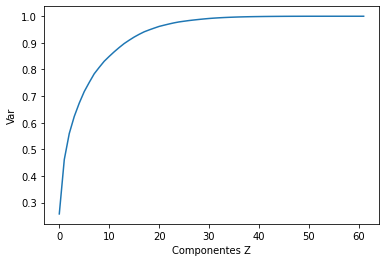

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=len(df_norm.columns))
PC=pca.fit_transform(df_norm)
PCdf=pd.DataFrame(data=PC)
var_ex=pca.explained_variance_ratio_
# trazar la ojiva
plt.plot (np.cumsum(var_ex))
plt.xlabel('Componentes Z')
plt.ylabel('Var')

In [ ]:
np.cumsum(var_ex)

array([0.25726378, 0.4614327 , 0.55944801, 0.62344976, 0.67356676,
       0.71691668, 0.75124757, 0.78378112, 0.80789429, 0.83081058,
       0.84902106, 0.86630345, 0.88235925, 0.8973361 , 0.9098829 ,
       0.92172086, 0.93204188, 0.94141306, 0.94862254, 0.9552982 ,
       0.9617075 , 0.96642975, 0.97097867, 0.97516228, 0.97866919,
       0.98128829, 0.98382581, 0.9859877 , 0.9880165 , 0.98987562,
       0.99158177, 0.99295939, 0.99413057, 0.99512567, 0.99594941,
       0.9966641 , 0.99728639, 0.99778061, 0.99820478, 0.99852379,
       0.99880308, 0.9990527 , 0.99925014, 0.99942181, 0.99956943,
       0.99969229, 0.99979109, 0.99985235, 0.99990519, 0.99994492,
       0.99997308, 0.99998454, 0.99999182, 0.99999654, 0.99999832,
       0.99999991, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

# **DATA CON COMPONENTES PRINCIPALES**

In [ ]:
#Vamos a escoger los primeros 30 componentes principales ya que con ellos se 
#obtiene una varianza superior al 98% y lo juntamos con las fechas y el precio de cierre
dff1=pd.DataFrame(df[['datetime','close']],)
dff2=PCdf.iloc[:,0:30]
#dff2=df_norm.iloc[:,3:4]
df_PCA=pd.concat([dff1,dff2], axis=1)
df_PCA.info


<bound method DataFrame.info of      datetime       close         0         1         2         3         4  \
0  2020-04-08  2749.97998 -7.870133  5.265003 -3.672866  2.852194  0.488105   
1  2020-04-09  2789.82007 -7.235514  4.334977  0.453846 -0.006689  4.605437   
2  2020-04-13  2761.62988 -6.607820  4.505328 -2.116910  3.018735  4.876413   
3  2020-04-14  2846.06006 -6.431355  2.546325  1.851707 -0.986343  2.898688   
4  2020-04-15  2783.36011 -3.722190  4.516380  1.517721  0.005958  0.970757   
..        ...         ...       ...       ...       ...       ...       ...   
64 2020-07-10  3185.04004 -1.292317 -4.915756 -1.957482 -0.774207 -0.531346   
65 2020-07-13  3155.21997  0.819528 -4.682838  0.048203 -0.807332  3.575816   
66 2020-07-14  3197.52002 -0.185112 -4.988210 -2.781588 -0.674432 -0.074705   
67 2020-07-15  3226.56006 -1.270758 -5.614332 -0.884091 -1.650916 -0.123479   
68 2020-07-16  3215.57007 -0.997007 -5.379189 -0.876307 -1.455143 -0.647879   

           5       

In [ ]:
#Establecemos la fecha como indice
df_PCA = df_PCA.set_index("datetime")

In [ ]:
# Sin preprocesar el precio queda así loss: 8872100.0000 - root_mean_squared_error: 2978.6072 - mean_absolute_error: 2975.9324 - mean_absolute_percentage_error: 99.9801
#Voy a probar estandarizando el precio de cierre

scaler = StandardScaler()

df_precio=df_PCA[['close']]
scaler.fit(df_precio)
scaled_precio = scaler.transform(df_precio)

dfst_precio=pd.DataFrame(scaled_precio)
dfst_precio.columns=['close']

dff1=df_PCA.drop(['close'],axis=1)

dff1=dff1.reset_index()
dff=pd.concat([dfst_precio,dff1],axis=1)
dff=dff.set_index('datetime')
dff


,close,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
datetime,,,,,,,,,,,,,,,,,,,,,
2020-04-08,-1.720139,-7.870133,5.265003,-3.672866,2.852194,0.488105,-0.149088,3.720455,-3.197405,-3.163318,...,0.588431,1.304598,-0.099074,-0.299675,0.001646,0.158632,-0.754818,-0.028024,0.444418,0.194337
2020-04-09,-1.442170,-7.235514,4.334977,0.453846,-0.006689,4.605437,4.823217,0.498356,-1.454947,-0.488119,...,-1.189796,-0.286815,0.301510,-0.090276,-0.131742,-0.422822,0.389154,-0.073672,-0.327051,-0.103694
2020-04-13,-1.638857,-6.607820,4.505328,-2.116910,3.018735,4.876413,-0.528971,-0.266524,1.024356,-0.476549,...,-0.794449,-0.105678,-0.127636,0.359654,0.140623,0.387960,0.022204,-0.036286,-0.074140,0.103175
2020-04-14,-1.049776,-6.431355,2.546325,1.851707,-0.986343,2.898688,0.514615,-0.011919,-1.099400,-0.070565,...,1.300115,0.318405,-0.035230,-0.632348,-0.808578,-0.207439,0.125669,0.420124,0.321014,-0.037586
2020-04-15,-1.487242,-3.722190,4.516380,1.517721,0.005958,0.970757,-0.908731,-0.147042,0.691975,-0.219853,...,1.277307,0.131363,0.204163,-0.578342,-0.050708,-0.241084,0.146356,-0.012279,-0.052197,-0.018964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-10,1.315330,-1.292317,-4.915756,-1.957482,-0.774207,-0.531346,0.660546,-1.672844,-0.464819,-1.035993,...,-0.037725,-1.085536,-0.509828,-0.224943,-0.152760,0.473521,-0.265906,-0.189422,-0.150394,-0.100926
2020-07-13,1.107272,0.819528,-4.682838,0.048203,-0.807332,3.575816,-0.537059,-2.759106,2.779235,-0.378345,...,0.037687,0.190845,0.587855,0.185924,-0.422377,0.710673,-0.196277,-0.490809,0.311503,-0.009765
2020-07-14,1.402405,-0.185112,-4.988210,-2.781588,-0.674432,-0.074705,-0.420035,-2.704367,1.389907,-0.014547,...,-0.286662,0.641106,-0.708494,1.209814,0.576038,0.011826,-0.709508,0.142678,-0.105697,-0.220841


# **CONJUNTOS DE DATOS DE ENTRENAMIENTO Y PRUEBA**

In [ ]:
#Parámetros importantes
n_days_before=5
n_days_future = 1
target_serie = "close"

In [ ]:
#Función para dividir el conjunto de datos en datos de entrenamiento, validación 
# y prueba
def split_data(data, test_ratio):
    n = len(data)
    X = pd.DataFrame(data)
    train_ratio = 1 - test_ratio
    data_train = X.iloc[0 : int(n * train_ratio)]
    data_test = X.iloc[int(n * train_ratio)-n_days_before-1 :]

    return data_train, data_test

In [ ]:
#Como vamos a trabajar con series temporales, escogeremos el 90% de datos para 
#el entrenamiento y los últimos 10% para el test.

test_ratio=0.1
data_train, data_test= split_data(dff, test_ratio)

# **TRANSFORMACIÓN DE LOS DATOS PARA PREDICCION DE SERIES TEMPORALES**

In [ ]:
# Funcion que convierte la serie en una tabla con los n_days_before y n_days_future seleccionados.
def series_to_supervised(
    df: pd.DataFrame,
    target_serie: str,
    n_days_before: int,
    n_days_future: int,
    dropnan=True,
):
    features = df.columns
    cols, names = list(), list()
    y_cols = []

    # input sequence (t-n, ... t-1)
    for i in range(n_days_before, 0, -1):
        cols.append(df.shift(i))
        names += [("%s (t-%d)" % (feature, i)) for j, feature in enumerate(features)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_days_future):
        cols.append(df[target_serie].shift(-i))
        if i == 0:
            y_cols += ["%s (t)" % y_tmp for y_tmp in [target_serie]]
        else:
            y_cols += ["%s (t+%d)" % (y_tmp, i) for y_tmp in [target_serie]]
    names += y_cols

    # put it all together
    supervised_data = pd.concat(cols, axis=1)
    supervised_data.columns = names

    # drop rows with NaN values
    if dropnan:
        supervised_data.dropna(inplace=True)
    return supervised_data

In [ ]:
# Funcion que convierte el DataFrame en una tabla con los n_days_before y n_days_future seleccionados.
def model_data_to_time_series(
    df: pd.DataFrame,
    target_serie: str,
    n_days_before: int,
    n_days_future: int,
):
    
    n_features = df.shape[1]

    supervised_data = series_to_supervised(df,target_serie,n_days_before,n_days_future)

    X_data = supervised_data.iloc[:, :-n_days_future]
    X_cols = X_data.columns.to_series()
    last_target_col = X_cols[
        X_cols.apply(lambda x: x.split(" ")[0] == target_serie)
    ].tolist()[-1]

    y_data = supervised_data.iloc[:, -n_days_future:]

    X = []
    for ind in range(n_features-1):
        tmp_X_serie = X_data.iloc[:, ind+1::n_features]
        X.append(tmp_X_serie.values)

    X = np.dstack(X)
    Y = y_data
    return X, Y

In [ ]:
#Transformación de los datos de entrenamiento, validación y prueba para el modelo
X_train, Y_train=model_data_to_time_series(data_train, target_serie,n_days_before,n_days_future)
X_test, Y_test=model_data_to_time_series(data_test, target_serie,n_days_before,n_days_future)

# **ENTRENAMIENTO DE LA RED**

In [ ]:
#Implementación del modelo en Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
#Añadimos Early Stopping para evitar el sobreajuste y guardamos el mejor el modelo
from keras.callbacks import ModelCheckpoint
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
mc = ModelCheckpoint('best_model_lstm.h5', monitor='loss', mode='min', 
                     verbose=1, save_best_only=True)

In [ ]:
def define_model(n_steps_before, n_series):
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_steps_before, n_series), 
                   return_sequences=True))
    model.add(Dropout(rate=0.05))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(rate=0.05))
    model.add(LSTM(units=128, return_sequences=False))
    model.add(Dense(units=1))

    # Utilizamos el optimizador Adam (Por defecto learning_rate=0.001)
    model.compile(optimizer="Adam",
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(),
                 tf.keras.metrics.MeanAbsoluteError(),
                 tf.keras.metrics.MeanAbsolutePercentageError()]
    )
    return model

In [ ]:
def train_model(X_train, y_train):
    n_samples, n_steps_before, n_series = X_train.shape

    model = define_model(n_steps_before, n_series)
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.05,
        epochs= 60,
        batch_size= 32,
        verbose= 1,
        callbacks=[callback, mc],
        shuffle=True
    )

    return model, history.history, n_series

In [ ]:
#Entrenamos el modelo y obtenemos el historial
model, history, n_series=train_model(X_train, Y_train)


Epoch 1/60
1/2 [==============>...............] - ETA: 5s - loss: 0.9337 - root_mean_squared_error: 0.9663 - mean_absolute_error: 0.8656 - mean_absolute_percentage_error: 101.4546
Epoch 1: loss improved from inf to 0.73991, saving model to best_model_lstm.h5
2/2 [==============================] - 7s 1s/step - loss: 0.7399 - root_mean_squared_error: 0.8602 - mean_absolute_error: 0.7526 - mean_absolute_percentage_error: 97.2921 - val_loss: 0.8757 - val_root_mean_squared_error: 0.9358 - val_mean_absolute_error: 0.9249 - val_mean_absolute_percentage_error: 85.2122
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 0.5127 - root_mean_squared_error: 0.7160 - mean_absolute_error: 0.6203 - mean_absolute_percentage_error: 91.1032
Epoch 2: loss improved from 0.73991 to 0.50126, saving model to best_model_lstm.h5
2/2 [==============================] - 0s 95ms/step - loss: 0.5013 - root_mean_squared_error: 0.7080 - mean_absolute_error: 0.6051 - mean_absolute_percentage_error: 81.267

# **CURVA DE APRENDIZAJE**

In [ ]:

def plot_history_training(history):
    fig = plt.figure(figsize=(18, 4))
    plt.subplot(1, 3, 1)
    plt.title("Raiz del error cuadrático medio (RMSE)")
    plt.plot(history["root_mean_squared_error"], label="train")
    plt.plot(history["val_root_mean_squared_error"], label="val")
    plt.grid(alpha=0.4)
    plt.xlabel('Epoca')
    plt.ylabel('RMSE')
    plt.title('Curva de Aprendizaje')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.title("Error absoluto promedio (MAE)")
    plt.plot(history["mean_absolute_error"], label="train")
    plt.plot(history["val_mean_absolute_error"], label="val")
    plt.grid(alpha=0.4)
    plt.xlabel('Epoca')
    plt.ylabel('MAE')
    plt.title('Curva de Aprendizaje')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.title("Porcentaje de error absoluto promedio (MAPE)")
    plt.plot(history["mean_absolute_percentage_error"], label="train")
    plt.plot(history["val_mean_absolute_percentage_error"], label="val")
    plt.grid(alpha=0.4)
    plt.xlabel('Epoca')
    plt.ylabel('MAPE')
    plt.title('Curva de Aprendizaje')
    plt.legend()

    return fig

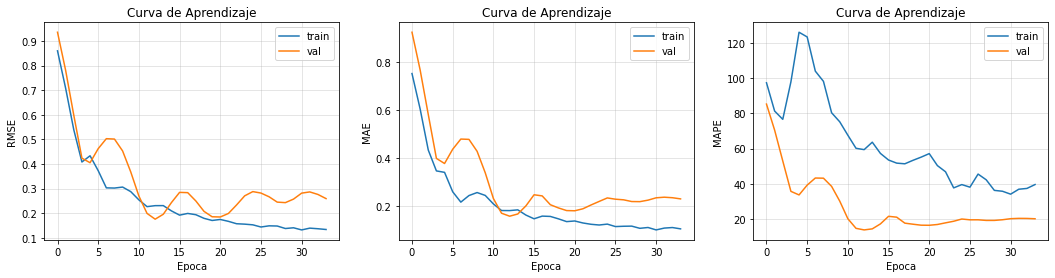

In [ ]:
# Ploteamos el history
fig= plot_history_training(history)

In [ ]:
from keras.models import load_model

model = load_model('best_model_lstm.h5', compile=False)

# **REENTRENAMIENTO SIN VALIDACION**

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
    
model.fit(X_train,Y_train, epochs= 20, batch_size= 32)


Epoch 1/20
2/2 [==============================] - 5s 28ms/step - loss: 0.0277
Epoch 2/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0257
Epoch 3/20
2/2 [==============================] - 0s 29ms/step - loss: 0.0329
Epoch 4/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0210
Epoch 5/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0233
Epoch 6/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0254
Epoch 7/20
2/2 [==============================] - 0s 24ms/step - loss: 0.0163
Epoch 8/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0177
Epoch 9/20
2/2 [==============================] - 0s 27ms/step - loss: 0.0165
Epoch 10/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0174
Epoch 11/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0154
Epoch 12/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0157
Epoch 13/20
2/2 [==============================] - 0s 22ms/st

# **PREDICCIONES DEL MODELO**

In [ ]:
# make predictions
trainPredict1 = model.predict(X_train)
testPredict1 = model.predict(X_test)

In [ ]:
# Se devuelven los valores originales
trainPredict=scaler.inverse_transform(trainPredict1)
testPredict=scaler.inverse_transform(testPredict1)
Y_train_o=scaler.inverse_transform(Y_train)
Y_test_o=scaler.inverse_transform(Y_test)

# **GRÁFICO CON PREDICCIONES**

In [ ]:
# shift train predictions for plotting
trainPredictPlot1 = np.empty_like(df[['close']].to_numpy())
trainPredictPlot1[:, :] = np.nan
trainPredictPlot1[n_days_before:len(trainPredict)+n_days_before, :] = trainPredict
trainPredictPlot1=pd.DataFrame(trainPredictPlot1)
trainPredictPlot1.columns=['Train']

# shift test predictions for plotting
testPredictPlot1 = np.empty_like(df[['close']].to_numpy())
testPredictPlot1[:, :] = np.nan
testPredictPlot1[len(trainPredict)+n_days_before-1:len(trainPredict)+n_days_before+len(testPredict), :] = testPredict
testPredictPlot1=pd.DataFrame(testPredictPlot1)
testPredictPlot1.columns=['Test']

#Uniendo en un solo DataFramePredict
PredictDatetime=df_PCA[['close']]
PredictDatetime=PredictDatetime.reset_index()

PredictPlot=pd.concat([PredictDatetime,trainPredictPlot1,testPredictPlot1], axis=1)

Text(0.5, 1.0, 'SP&500')

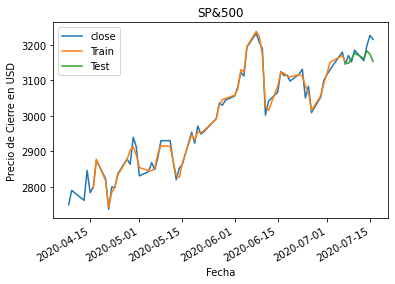

In [ ]:
PredictPlot.plot(x="datetime")
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre en USD')
plt.title('SP&500')

# **METRICAS**

In [ ]:
Y_trainf=pd.DataFrame(Y_train_o[:,0])
Y_testf=pd.DataFrame(Y_test_o[:,0])

In [ ]:
import math
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

# calculate root mean squared error
train_rmse_Score = math.sqrt(mse(Y_trainf, trainPredict))
print('Train Score: %.2f RMSE' % (train_rmse_Score))
test_rmse_Score = math.sqrt(mse(Y_testf, testPredict))
print('Test Score: %.2f RMSE' % (test_rmse_Score))

# calculate mean absolute error
train_mae_Score = mae(Y_trainf, trainPredict)
print('Train Score: %.2f MAE' % (train_mae_Score))
test_mae_Score = mae(Y_testf, testPredict)
print('Test Score: %.2f MAE' % (test_mae_Score))

# calculate root mean squared error
train_mape_Score = mape(Y_trainf, trainPredict)
print('Train Score: %.4f MAPE' % (train_mape_Score))
test_mape_Score = mape(Y_testf, testPredict)
print('Test Score: %.4f MAPE' % (test_mape_Score))


Train Score: 14.43 RMSE
Test Score: 30.84 RMSE
Train Score: 11.08 MAE
Test Score: 22.65 MAE
Train Score: 0.0037 MAPE
Test Score: 0.0071 MAPE


# **REENTRENAMIENTO CON TODOS LOS DATOS**

In [ ]:
#Preparación de los datos
X_data, Y_data=model_data_to_time_series(dff, target_serie,n_days_before,n_days_future)

In [ ]:
#Ajuste del modelo con todos los datos
model.compile(optimizer='adam', loss='mean_squared_error') 
model.fit(X_data,Y_data, epochs= 20, batch_size= 32)

Epoch 1/20
2/2 [==============================] - 4s 22ms/step - loss: 0.0252
Epoch 2/20
2/2 [==============================] - 0s 23ms/step - loss: 0.0170
Epoch 3/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0221
Epoch 4/20
2/2 [==============================] - 0s 23ms/step - loss: 0.0157
Epoch 5/20
2/2 [==============================] - 0s 23ms/step - loss: 0.0214
Epoch 6/20
2/2 [==============================] - 0s 23ms/step - loss: 0.0141
Epoch 7/20
2/2 [==============================] - 0s 25ms/step - loss: 0.0144
Epoch 8/20
2/2 [==============================] - 0s 23ms/step - loss: 0.0119
Epoch 9/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0134
Epoch 10/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0116
Epoch 11/20
2/2 [==============================] - 0s 24ms/step - loss: 0.0095
Epoch 12/20
2/2 [==============================] - 0s 23ms/step - loss: 0.0089
Epoch 13/20
2/2 [==============================] - 0s 23ms/st

In [ ]:
# Predicciones del modelo para el conjunto de datos
dataPredict1 = model.predict(X_data)

In [ ]:
# Valores originales
dataPredict=scaler.inverse_transform(dataPredict1)
Y_data_o=scaler.inverse_transform(Y_data)

In [ ]:
# shift train predictions for plotting
dataPredictPlot1 = np.empty_like(df[['close']].to_numpy())
dataPredictPlot1[:, :] = np.nan
dataPredictPlot1[n_days_before:len(dataPredict)+n_days_before, :] = dataPredict
dataPredictPlot1=pd.DataFrame(dataPredictPlot1)
dataPredictPlot1.columns=['Model']

#Uniendo en un solo DataFramePredict
PredictDatetime=df_PCA[['close']]
PredictDatetime=PredictDatetime.reset_index()

PredictPlot2=pd.concat([PredictDatetime,dataPredictPlot1], axis=1)

Text(0.5, 1.0, 'SP&500')

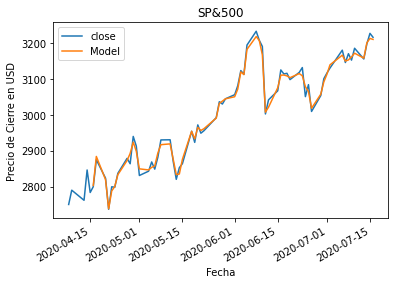

In [ ]:
PredictPlot2.plot(x="datetime")
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre en USD')
plt.title('SP&500')

# **MÉTRICA CON TODOS LOS DATOS**

In [ ]:
Y_dataf=pd.DataFrame(Y_data_o[:,0])

# calculate root mean squared error
train_rmse_Score = math.sqrt(mse(Y_dataf, dataPredict))
print('Train Score: %.2f RMSE' % (train_rmse_Score))

# calculate mean absolute error
train_mae_Score = mae(Y_dataf, dataPredict)
print('Train Score: %.2f MAE' % (train_mae_Score))

# calculate root mean squared error
train_mape_Score = mape(Y_dataf, dataPredict)
print('Train Score: %.4f MAPE' % (train_mape_Score))



Train Score: 11.53 RMSE
Train Score: 9.38 MAE
Train Score: 0.0031 MAPE


# **PREDICCIONES FINALES**

In [ ]:
ultimo=dff.tail(n_days_before)
ult_reg=ultimo.tail(1)
ultimo=ultimo.append(ult_reg)
#Preparación de los datos
X_dataF, Y_dataF=model_data_to_time_series(ultimo, target_serie,n_days_before,n_days_future)
dataPredictF = model.predict(X_dataF)
dataPredictF=scaler.inverse_transform(dataPredictF)

In [ ]:
dataPredictF

array([[3206.7827]], dtype=float32)

# **Direct multi-step forecasting**

#https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html